# The geometric nature of PFRs and CSTRs
## Python imports

In [1]:
import scipy as sp
from scipy.integrate import odeint
import scipy.linalg
import scipy.optimize

import matplotlib.pyplot as plt

from ipywidgets import interact

%matplotlib inline
plt.style.use("ggplot")

## Define kinetics

We use the autocatalytic reaction:

$$A + B \rightarrow 2B$$
$$B \rightarrow C$$

to demonstrate the geometric relationship between the rate field and fundamental reactor types.

In [2]:
#Autocatalytic kinetics
def rate_fn(C,t):
    
    #Concentration vector: C = [cA, cB]
    cA = C[0]
    cB = C[1]
    
    #rate constants
    k1 = 1.0
    k2 = 1.0
    
    rA = -k1*cA*cB
    rB = k1*cA*cB - k2*cB**2
    
    dC = sp.array([rA, rB])
    return dC

Define an integration range for the PFR

In [3]:
t_end = 50
N_pts = 100

ts = sp.logspace(-3,sp.log10(t_end),N_pts)

## Compute rate field based on kinetics
We calculate the rate field for demonstrating the graphical properties of reactors later on

In [4]:
#calc rate vectors
x_range = sp.linspace(0,1,20)
y_range = sp.linspace(0,1,20)

Rs = sp.zeros((len(x_range)*len(y_range),2))
Cs = sp.zeros((len(x_range)*len(y_range),2))

k = 0
for xi in x_range:
    for yi in y_range:
        Ci = sp.array([xi,yi])
        ri = rate_fn(Ci,[])
        
        #normalise rate vectors
        ri_mag = scipy.linalg.norm(ri, 2)
        ri_n = ri/ri_mag

        Rs[k,:] = ri_n
        Cs[k,:] = Ci
        k += 1

C:\Users\A0017697\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in divide


## Plotting function

In [5]:
def plot_fn(CfA=1.0, CfB=0.01):
    Cf = sp.array([CfA, CfB])
    
    #integrate PFR
    pfr_cs = odeint(rate_fn,Cf,ts)
    
    #generate figure
    fig = plt.figure()
    ax = fig.gca()
    plt.hold(True)
    
    #print Rs
    plt.quiver(Cs[:,0],Cs[:,1],Rs[:,0],Rs[:,1])  
    
    #plot PFR
    plt.plot(pfr_cs[:,0], pfr_cs[:,1], 'r-')
    
    #feed point
    plt.plot(CfA,CfB, 'y^')
    #ax.text(CfA*0.95, CfB, 'Cf')
    
    plt.title('PFR trajectory')
    plt.xlabel('$c_A$ (mol/L)')
    plt.ylabel('$c_B$ (mol/L)')
    plt.axis([0,1, 0,1])
    
    plt.show()

## Interactive PFR trajectory 
### (ADD A CONTROL TO ADJUST THE RATE CONSTANTS SO THAT THEY CAN BE CHANGED IN REAL-TIME AS WELL)

Use the sliders to adjust the feed concentration of the PFR. Notice how rate vectors evaluated on the resulting PFR trajectory are *always* tangent to the trajectory. The shape of the curve is defined by two factors:
- The rate field (kinetics)
- The feed point

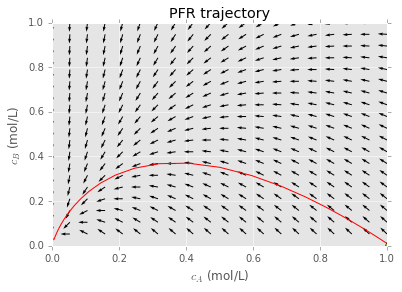

<function __main__.plot_fn>

In [6]:
interact(plot_fn, CfA=(0,1,0.01), CfB=(0,1,0.01))

## CSTR locus

We can do the same with the CSTR locus. However, since the CSTR locus is typically difficult to solve for analytically, we must rely on numerical computation. Intead of making the CSTR locus interactive (which would be too slow to display smoothly), we rather specify a feed point and then compute the associated CSTR locus in a separate cell, which can then be statically displayed.

In [7]:
def cstr_plot_fn(CfA=1.0, CfB=0.0, tau=1.0):
    Cf = sp.array([CfA, CfB])
    
    def cstr_fn(Ci):
        ri = rate_fn(Ci,[])
        f = Cf + tau*ri - Ci
        
        return f
    
    #attempt to solve for CSTR solution
    Ci = scipy.optimize.newton_krylov(cstr_fn, [0.5,0.5], f_tol=1e-4)
    
    #print Ci
    
    plt.figure()
    plt.hold(True)
    
    #plot rate field
    plt.quiver(Cs[:,0],Cs[:,1],Rs[:,0],Rs[:,1])
    
    #plot feed
    plt.plot(CfA,CfB, 'g^')
    
    #plot solution
    #plt.plot(Ci[0],Ci[1], 'rx')
    ri = rate_fn(Ci,[])
    plt.quiver(Ci[0],Ci[1], ri[0],ri[1])
    
    #plot str line between Cf and Ci
    plt.plot([Ci[0],Cf[0]],[Ci[1],Cf[1]], 'b--')
    
    plt.title('CSTR solution = [%.2f, %.2f] mol/L'%(Ci[0], Ci[1]))
    plt.axis([-0.1,1.1, -0.1,1.1])
    plt.xlabel('cA (mol/L)')
    plt.ylabel('cB (mol/L)')
    
    plt.show()
    

## Interactive CSTR demo

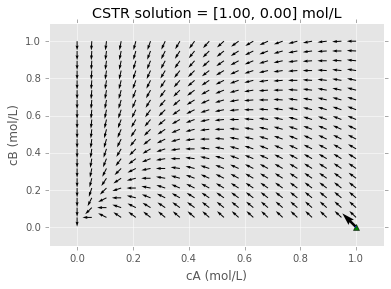

<function __main__.cstr_plot_fn>

In [8]:
interact(cstr_plot_fn, CfA=(0,1,0.01), CfB=(0,1,0.01), tau=(0,50,0.01))

## Brute-force CSTR solution

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


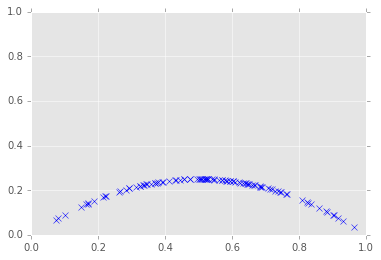

In [9]:
#CSTR feed point
Cf = sp.array([1.0, 0.0])

#solve for CSTR solutions
tol = 1e-5
found_pts = 0
cstr_cs = sp.zeros([100,2])
k=0
while found_pts < 100:
    Ci = scipy.random.rand(2)
    
    vi = Ci-Cf
    ri = rate_fn(Ci,[])
    
    ri_n = ri/scipy.linalg.norm(ri)
    vi_n = vi/scipy.linalg.norm(vi)
    
    n = sp.fabs(sp.inner(vi_n,ri_n)) - 1.0 #xTy = 1 for vector x to be colinear to vector y
    
    if sp.fabs(n)<=tol: 
        found_pts += 1
        print found_pts
        
        cstr_cs[k,:] = Ci
        k=k+1

        
#plot CSTR locus
plt.figure()

plt.plot(cstr_cs[:,0],cstr_cs[:,1], 'bx')

plt.axis([0,1,0,1])
plt.show()